In [1]:
def update_box_reached(change):
    print("aa")
    plt.bar(["Reached", "Cancelled"], [n_goals_reached, n_goals_cancelled], align='center', width=0.8, color=['green', 'red'])
    plt.show()  

In [2]:
import ipywidgets as widgets

box_reached = widgets.IntText(value=0, disabled=True)

display(box_reached)
    
box_reached.observe(update_box_reached, 'value')

IntText(value=0, disabled=True)

In [3]:
import rospy
from geometry_msgs.msg import PoseStamped
from nav_msgs.msg import Odometry
from my_assignment_2.msg import PosVel
from assignment_2_2022.msg import PlanningActionResult

import actionlib # Bring in the SimpleActionClient

# Bring in the PlanningAction type, composed by the types PlanningGoal, PlanningResult and PlanningFeedback
from assignment_2_2022.msg import PlanningAction, PlanningGoal

# Since we'll publish within the callback function, we have to define the publisher globally
pub = rospy.Publisher("/pos_vel", PosVel, queue_size=10)

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation

class Visualiser:
    def __init__(self):
        self.fig, self.ax = plt.subplots()
        self.ln, = plt.plot([], [], 'ro')
        self.x_data, self.y_data = [] , []
        
    def plot_init(self):
        self.ax.set_xlim(-10, 10)
        self.ax.set_ylim(-10, 10)
        return self.ln
    
    def odom_callback(self, msg):
        
        my_pos_vel = PosVel() # this is the msg we'll publish
    
        # Fill the four fields relying on the data received via the topic /odom
        my_pos_vel.x = msg.pose.pose.position.x
        my_pos_vel.y = msg.pose.pose.position.y
        my_pos_vel.vel_x = msg.twist.twist.linear.x
        my_pos_vel.vel_z = msg.twist.twist.angular.z

        pub.publish(my_pos_vel) # publish
    
        self.y_data.append(msg.pose.pose.position.y)
        self.x_data.append(msg.pose.pose.position.x)
        
    def update_plot(self, frame):
        self.ln.set_data(self.x_data, self.y_data)
        return self.ln  

In [5]:
# If the goal has been successfully reached (status=3), increment the parameter related to the number of goals reached
def callback_result(result):
    
    if result.status.status == 3:
        print("Goal reached!\n")
        global n_goals_reached
        n_goals_reached += 1
        rospy.set_param('goals_reached', n_goals_reached)
        
        global box_reached
        box_reached.value += 1

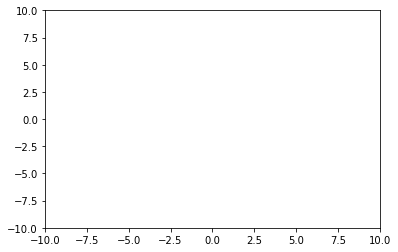

Waiting for the action server to start...
Action server up and running!



In [6]:
# Initialize a rospy node so that the SimpleActionClient can publish and subscribe over ROS
rospy.init_node('planning_client')

# Create an instance of the class Visualiser
vis = Visualiser()

# FuncAnimation
ani = FuncAnimation(vis.fig, vis.update_plot, init_func=vis.plot_init)
plt.show(block=False)

# Subscribe to the topics /odom and /reaching_goal/result
rospy.Subscriber("/odom", Odometry, vis.odom_callback)
rospy.Subscriber("/reaching_goal/result", PlanningActionResult, callback_result)

# Counters for the number of goals reached and cancelled, in total
n_goals_reached = 0
n_goals_cancelled = 0

# Initialize the parameters, in the ROS parameter service, related to these counters
rospy.set_param('goals_reached', n_goals_reached)
rospy.set_param('goals_cancelled', n_goals_cancelled)

# Create the SimpleActionClient. The service is called '/reaching_goal' and the type of action is 'PlanningAction'
client = actionlib.SimpleActionClient('reaching_goal', PlanningAction)

# Wait until the action server has started up and started listening for goals
print("Waiting for the action server to start...")
client.wait_for_server()
print("Action server up and running!\n")

In [7]:
import ipywidgets as widgets

# Get a new target from user input

print("To send a new target, specify the x and y coordinates and click \'Send\':\n")
print("To cancel the current target, click \'Cancel\':\n")
print("x = ")
x = widgets.FloatText()
display(x)
print("y = ")
y = widgets.FloatText()
display(y)

send_button = widgets.Button(
    description='Send',
    disabled=False,
    button_style='success'
)

cancel_button = widgets.Button(
    description='Cancel',
    disabled=False,
    button_style='danger'
)

output = widgets.Output()

display(send_button, output)
display(cancel_button, output)

To send a new target, specify the x and y coordinates and click 'Send':

To cancel the current target, click 'Cancel':

x = 


FloatText(value=0.0)

y = 


FloatText(value=0.0)

Button(button_style='success', description='Send', style=ButtonStyle())

Output()

Button(button_style='danger', description='Cancel', style=ButtonStyle())

Output()

In [8]:
# If the user clicks the 'cancel' button, cancel the current goal and increment the parameter related to the number 
# of goals cancelled
def on_cancel_button_clicked(b):
        
    client.cancel_goal()
    print("Goal cancelled\n")
    global n_goals_cancelled
    n_goals_cancelled += 1
    rospy.set_param('goals_cancelled', n_goals_cancelled)

In [9]:
# If the user clicks the 'send' button...
def on_send_button_clicked(b):
        
    # Create a goal to send to the action server
    my_goal_pose = PoseStamped()
    my_goal_pose.pose.position.x = x.value
    my_goal_pose.pose.position.y = y.value
    goal = PlanningGoal(target_pose = my_goal_pose)

    # Send the goal to the action server
    client.send_goal(goal)

    print("Goal (" + str(x.value) + ", " + str(y.value) + ") sent")
    print("Heading to the goal...")

In [10]:
send_button.on_click(on_send_button_clicked)
cancel_button.on_click(on_cancel_button_clicked)

In [11]:
print("Distance to the closest obstacle: ")
box = widgets.FloatText(value=-1, disabled = True, layout = widgets.Layout(width='200px'))

display(box)

Distance to the closest obstacle: 


FloatText(value=-1.0, disabled=True, layout=Layout(width='200px'))

In [12]:
def callback_scan(msg):
    
    min_val = msg.range_max
    
    a = msg.ranges[0]
    
    for i in range(len(msg.ranges)):
        
        if (msg.ranges[i] < min_val) and (msg.ranges[i] >= msg.range_min) and (msg.ranges[i] <= msg.range_max):
            
            min_val = msg.ranges[i]
    
    global box
    box.value = min_val

In [13]:
from sensor_msgs.msg import LaserScan

# Subscribe to the topic /scan
s = rospy.Subscriber("/scan", LaserScan, callback_scan)

In [14]:
print(n_goals_reached)
print(n_goals_cancelled)

0
0


In [15]:
%matplotlib widget

plt.bar(["Reached", "Cancelled"], [n_goals_reached, n_goals_cancelled], align='center', width=0.8, color=['green', 'red'])

plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …